In [1]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [2]:
REPO = "https://github.com/annanasnas/semantic_segmentation-25.git"
!git clone $REPO
%cd /content/semantic_segmentation-25
!pip install -q -r requirements.txt pyyaml

Cloning into 'semantic_segmentation-25'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 127 (delta 47), reused 105 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (127/127), 221.38 KiB | 9.63 MiB/s, done.
Resolving deltas: 100% (47/47), done.
/content/semantic_segmentation-25


## Config

In [3]:
import yaml

with open("configs/deeplabv2.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

!python scripts/download_data.py

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = cfg["train"]["batch_size"]
epochs = cfg["train"]["epochs"]
data_dir = cfg["data"]["root"]
learning_rate = cfg["train"]["lr"]
img_size = cfg["data"]["img_size"]
name = cfg["model"]["name"]

Downloading...
From (original): https://drive.google.com/uc?id=1qWyPvG6KWbifoUr0mkNpctY87_pg2l-o
From (redirected): https://drive.google.com/uc?id=1qWyPvG6KWbifoUr0mkNpctY87_pg2l-o&confirm=t&uuid=0b8579c8-91e7-433b-9987-dc1061ad6deb
To: /content/semantic_segmentation-25/datasets/data/Cityscapes.zip
100% 4.97G/4.97G [01:15<00:00, 65.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1VOmwEwd73ktbCaSlugCPRGEwq9QY85aW
From (redirected): https://drive.google.com/uc?id=1VOmwEwd73ktbCaSlugCPRGEwq9QY85aW&confirm=t&uuid=67c70090-443a-4293-b486-adef82f7ab1f
To: /content/semantic_segmentation-25/models/deeplabv2/DeepLab_resnet_pretrained_imagenet.pth
100% 177M/177M [00:00<00:00, 272MB/s]


## DataLoaders

In [4]:
from datasets.cityscapes import CityScapes
from torch.utils.data import DataLoader
from torchvision import transforms


imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_dataset = CityScapes(
    root_dir=data_dir,
    split="train",
    image_transform=image_transforms,
    image_size=img_size
)

val_dataset = CityScapes(
    root_dir=data_dir,
    split="val",
    image_transform=image_transforms,
    image_size=img_size
)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Training

Deeplab pretraining loading...


/usr/local/lib/python3.11/dist-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


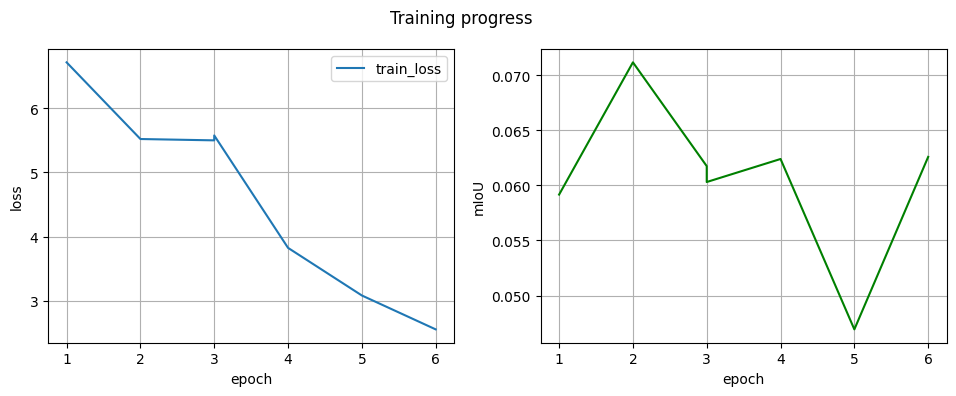

Epoch 4/50 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/50, Loss: 3.8241


Per-class IoU
Road            : 0.6049
Sidewalk        : 0.0000
Building        : 0.3150
Wall            : 0.0000
Fence           : 0.0000
Pole            : 0.0000
Traffic light   : 0.0000
Traffic sign    : 0.0000
Vegetation      : 0.1467
Terrain         : 0.0000
Sky             : 0.1188
Person          : 0.0000
Rider           : 0.0000
Car             : 0.0000
Truck           : 0.0000
Bus             : 0.0000
Train           : 0.0000
Motorcycle      : 0.0000
Bicycle         : 0.0000
Mean IoU: 0.0624
Best mIoU = 0.0624


Epoch 5/50, Loss: 3.0823


Per-class IoU
Road            : 0.6957
Sidewalk        : 0.0000
Building        : 0.1057
Wall            : 0.0000
Fence           : 0.0000
Pole            : 0.0000
Traffic light   : 0.0000
Traffic sign    : 0.0000
Vegetation      : 0.0168
Terrain         : 0.0000
Sky             : 0.0735
Person          : 0.0000
Rider           : 0.0000
Car             : 0.0000
Truck           : 0.0000
Bus             : 0.0000
Train           : 0.0000
Motorcycle      : 0.0000
Bicycle         : 0.0000
Mean IoU: 0.0469


Epoch 6/50, Loss: 2.5542


Per-class IoU
Road            : 0.7794
Sidewalk        : 0.0082
Building        : 0.2285
Wall            : 0.0000
Fence           : 0.0000
Pole            : 0.0000
Traffic light   : 0.0000
Traffic sign    : 0.0000
Vegetation      : 0.1023
Terrain         : 0.0019
Sky             : 0.0686
Person          : 0.0000
Rider           : 0.0000
Car             : 0.0000
Truck           : 0.0000
Bus             : 0.0000
Train           : 0.0000
Motorcycle      : 0.0000
Bicycle         : 0.0000
Mean IoU: 0.0626
Best mIoU = 0.0626


KeyboardInterrupt: 

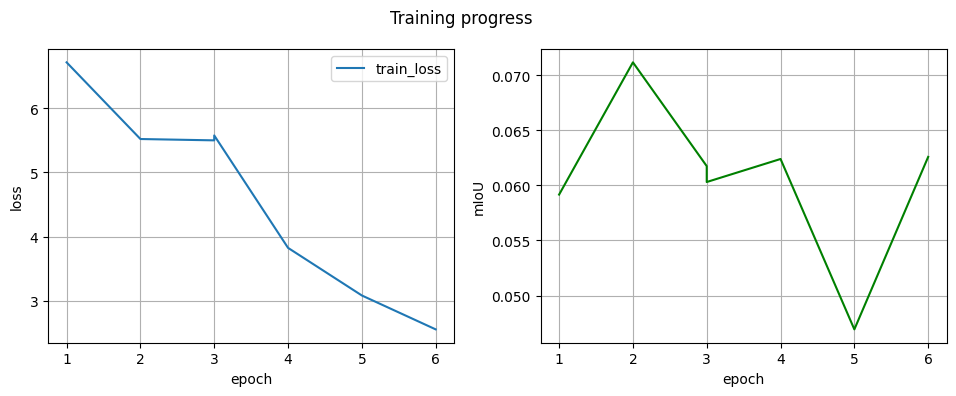

In [8]:
import torch.optim as optim
import torch.nn as nn
from models.deeplabv2.deeplabv2 import get_deeplab_v2
from scripts.train import train_model
from torch.amp import autocast, GradScaler
from scripts.checkpoint import Checkpoint
from pathlib import Path
import pandas as pd

model = get_deeplab_v2()
optimizer = optim.SGD(model.optim_parameters(lr=learning_rate), momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)
scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=50, power=0.9)
scaler = GradScaler()

model.to(device)

ckpt_dir = Path("/checkpoints") / name
log_csv = ckpt_dir / "log.csv"
plot_png = ckpt_dir / "plot.png"
ckpt_mgr = Checkpoint(ckpt_dir)

best_path = ckpt_dir / "best.pth"

if best_path.exists():
    ckpt = torch.load(best_path, map_location="cpu", weights_only=False)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    scaler.load_state_dict(ckpt["scaler"])
    scheduler.load_state_dict(ckpt["scheduler"])
    start_epoch = ckpt["epoch"]
    best_miou   = ckpt["best_miou"]
    df_prev = pd.read_csv(log_csv)
    metrics = df_prev.to_dict("list")
else:
    start_epoch = 0
    best_miou   = 0
    metrics = {"epoch": [], "train_loss": [], "val_loss": [], "val_miou": []}

train_model(model, train_dataloader, val_dataloader,
            device, epochs, autocast, scaler,
            optimizer, criterion, scheduler,
            ckpt_mgr, start_epoch, best_miou,
            log_csv, plot_png, metrics)